<a href="https://colab.research.google.com/github/rfdornelles/mds_ML_project/blob/main/plot_scenarios_xgboost_karon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/rfdornelles/mds_ML_project/main/data/karon2.csv")

In [2]:
df.head()

,year,country,temp,population,qnt_death_heat_cold_exposure,temp_diff
0,1991,Albania,6.219891,3266790,5,0.050951
1,1992,Albania,6.284930,3247039,5,0.065040
2,1993,Albania,6.324316,3227287,5,0.039385
3,1994,Albania,6.357706,3207536,5,0.033390
4,1995,Albania,6.402805,3187784,6,0.045099


In [3]:
X = df.drop(["qnt_death_heat_cold_exposure", "country", "temp_diff"], axis = 1).to_numpy()
y = df["qnt_death_heat_cold_exposure"].to_numpy()

In [4]:
#https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn/notebook 

In [5]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score

import xgboost as xgb

In [6]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [7]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [8]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

mse=mean_squared_error(y, y_pred)

print(np.sqrt(mse))
print("R2:", r2_score(y, y_pred))

67.34764630310802
R2: 0.9861534867247158


In [9]:
xgb_model

XGBRegressor(objective='reg:squarederror', random_state=42)

In [10]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

scores = []

In [11]:
for train_index, test_index in kfold.split(X):   
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    
    scores.append(mean_squared_error(y_test, y_pred))
    
display_scores(np.sqrt(scores))
print("R2:", r2_score(y_test, y_pred))

Scores: [102.90442912  86.73481857  97.15700031 117.28103054 122.66048715]
Mean: 105.348
Std: 13.127
R2: 0.9437446154139051


In [12]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

scores = cross_val_score(xgb_model, X, y, scoring="neg_mean_squared_error", cv=5)

display_scores(np.sqrt(-scores))

Scores: [ 256.57654267 1071.80656933  173.99060636  128.40856853 1207.45216773]
Mean: 567.647
Std: 470.784


In [18]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 5)


Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: -0.562 (std: 0.735)
Parameters: {'colsample_bytree': 0.9040922615763338, 'gamma': 0.2252496259847715, 'learning_rate': 0.033979488347959955, 'max_depth': 2, 'n_estimators': 113, 'subsample': 0.9233589392465844}

Model with rank: 2
Mean validation score: -0.565 (std: 0.739)
Parameters: {'colsample_bytree': 0.7902634929450308, 'gamma': 0.1424202471887338, 'learning_rate': 0.041066084206359835, 'max_depth': 2, 'n_estimators': 101, 'subsample': 0.8010716092915446}

Model with rank: 3
Mean validation score: -0.586 (std: 0.758)
Parameters: {'colsample_bytree': 0.7516959613604889, 'gamma': 0.09614450940433539, 'learning_rate': 0.042260584879943656, 'max_depth': 2, 'n_estimators': 117, 'subsample': 0.7114361356127834}

Model with rank: 4
Mean validation score: -0.611 (std: 0.435)
Parameters: {'colsample_bytree': 0.9266653415629146, 'gamma': 0.11439908274581123, 'learning_rate': 0.0530939729

In [14]:
mse = mean_squared_error(y_test, search.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 51675.1158


In [19]:
best_params = {'colsample_bytree': 0.9040922615763338, 'gamma': 0.2252496259847715, 'learning_rate': 0.033979488347959955, 'max_depth': 2, 'n_estimators': 113, 'subsample': 0.9233589392465844}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", 
                             random_state=42, 
                             params = best_params)

xgb_model.fit(X_train, y_train)

pred = xgb_model.predict(X_test)



In [20]:
from sklearn.metrics import r2_score, mean_squared_error


R2 = r2_score(y_test, pred)


n = X.shape[0]
p = X.shape[1]
Adj_r2 = 1-(1-R2)*(n-1)/(n-p-1)

rmse = mean_squared_error(y_test, pred, squared = False)
mse = mean_squared_error(y_test, pred, squared = True)

print("R2:", R2)
print("AdjR2:", Adj_r2)
print("RMSE:", rmse)
print("MSE:", mse)

R2: 0.9437446154139051
AdjR2: 0.9436404387757827
RMSE: 122.66048714938465
MSE: 15045.595107724355


In [21]:
# Predictions

df_rcp45 = pd.read_csv("https://github.com/rfdornelles/mds_ML_project/raw/main/data/pred_y_2022_2050_rcp45.csv")

X_rcp45 = df_rcp45[df_rcp45["country"] == "Germany"].drop(["country"],axis = 1)

In [22]:
y_rcp45 = xgb_model.predict(X_rcp45.to_numpy())

In [23]:
X_rcp45["pred_rcp45"] = y_rcp45.round()

RCP 85

In [25]:
# Predictions

df_rcp85 = pd.read_csv("https://github.com/rfdornelles/mds_ML_project/raw/main/data/pred_y_2022_2050_rcp85.csv")

X_rcp85 = df_rcp85[df_rcp85["country"] == "Germany"].drop(["country"],axis = 1)

In [26]:
y_rcp85 = xgb_model.predict(X_rcp85.to_numpy())

In [27]:
X_rcp85["pred_rcp85"] = y_rcp85.round()

In [28]:
plot_df = pd.DataFrame()
plot_df["year"] = range(1991, 2051)

In [29]:
df_actual_values = df[df["country"] == "Germany"][["year", "qnt_death_heat_cold_exposure"]]

In [30]:
df_rcp85 = X_rcp85[["year", "pred_rcp85"]]

In [31]:
df_rcp45 = X_rcp45[["year", "pred_rcp45"]]

In [33]:
plot_df = plot_df.merge(df_actual_values, on = "year", how = "left")

plot_df = plot_df.merge(df_rcp45, on = "year", how = "left")

plot_df = plot_df.merge(df_rcp85, on = "year", how = "left")

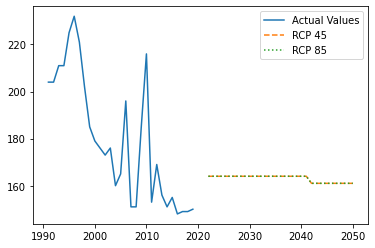

In [34]:
# importing package
import matplotlib.pyplot as plt

# plot lines

plt.plot(df_actual_values["year"], df_actual_values["qnt_death_heat_cold_exposure"], label = "Actual Values")
plt.plot(df_rcp45["year"], df_rcp45["pred_rcp45"], linestyle="dashed", label = "RCP 45")
plt.plot(df_rcp85["year"], df_rcp85["pred_rcp85"], linestyle="dotted", label = "RCP 85")
plt.legend()
plt.show()
